### Regression Model Comparison using `PyCaret`

In [1]:
# !pip install pycaret # if necessary

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf

# from statsmodels.formula.api import ols
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# !pip install pycaret
from pycaret.regression import *

import seaborn as sns

1. Download IONQ data using `yfinance`

In [3]:
stockCode = "IONQ"
# startDate = "2022-07-01"
# endDate = "2023-06-30"

In [4]:
ticker = yf.Ticker(stockCode)
# price_hist = ticker.history(start=startDate, end=endDate)
price_hist = ticker.history(period="max", interval="1d")

price_hist.index = [x.date() for x in price_hist.index]
# date_range = pd.date_range(startDate, endDate)
# price_hist = price_hist.reindex(date_range)
price_hist.shape

(651, 7)

2. Add features
- Shift: Price before n days
- MA: Avg. price for last n days
- VolAvg: Avg. vol for last n days

In [5]:
close = price_hist[["Close", "Volume"]].copy()

close["Shift_1"] = close["Close"].shift(1)
close["Shift_5"] = close["Close"].shift(5)
close["Shift_20"] = close["Close"].shift(20)
close["Shift_60"] = close["Close"].shift(60)
close["Shift_120"] = close["Close"].shift(120)
close["Shift_240"] = close["Close"].shift(240)

close["MA_5"] = close["Close"].rolling(5).mean()
close["MA_20"] = close["Close"].rolling(20).mean()
close["MA_60"] = close["Close"].rolling(60).mean()
close["MA_120"] = close["Close"].rolling(120).mean()
close["MA_240"] = close["Close"].rolling(240).mean()

close["Vol_1"] = close["Volume"].shift(1)
close["VolAvg_5"] = close["Volume"].rolling(5).mean()
close["VolAvg_20"] = close["Volume"].rolling(20).mean()
close["VolAvg_60"] = close["Volume"].rolling(60).mean()
close["VolAvg_120"] = close["Volume"].rolling(120).mean()
close["VolAvg_240"] = close["Volume"].rolling(240).mean()

In [6]:
close = close.dropna()
print(close.shape)

(411, 19)


In [7]:
close.head(5)

Close    Volume    Shift_1    Shift_5   Shift_20  Shift_60  \
2021-12-15  17.840000   6809000  16.100000  20.969999  26.379999     10.05   
2021-12-16  16.059999   7132400  17.840000  18.610001  31.000000      9.99   
2021-12-17  16.770000  11570300  16.059999  18.570000  27.959999     10.01   
2021-12-20  15.280000   5446000  16.770000  16.670000  28.010000     11.30   
2021-12-21  16.180000   3845800  15.280000  16.100000  23.180000     11.94   

            Shift_120  Shift_240    MA_5    MA_20      MA_60     MA_120  \
2021-12-15      10.39      10.80  17.558  22.1605  15.928500  13.006167   
2021-12-16      10.49      11.11  17.048  21.4135  16.029667  13.052583   
2021-12-17      10.55      11.05  16.688  20.8540  16.142333  13.104417   
2021-12-20      10.69      11.11  16.410  20.2175  16.208667  13.142667   
2021-12-21      10.70      11.01  16.426  19.8675  16.279333  13.188333   

               MA_240       Vol_1   VolAvg_5  VolAvg_20     VolAvg_60  \
2021-12-15  12.002708   5066300.0  5484760.0  8024910.0  6.950093e+06   
2021-12-16  12.023333   6809000.0  5658380.0  7365160.0  7.011992e+06   
2021-12-17  12.047167   7132400.0  7247060.0  6823755.0  7.136543e+06   
2021-12-20  12.064542  11570300.0  7204800.0  6682255.0  7.012695e+06   
2021-12-21  12.086083   5446000.0  6960700.0  6265540.0  6.910717e+06   

              VolAvg_120    VolAvg_240  
2021-12-15  3.746622e+06  2.182983e+06  
2021-12-16  3.801465e+06  2.212012e+06  
2021-12-17  3.895502e+06  2.259490e+06  
2021-12-20  3.937217e+06  2.281790e+06  
2021-12-21  3.967204e+06  2.297241e+06

3. Visualization

In [8]:
close = close.drop(columns=["Volume"])
print(close.shape)

(411, 18)


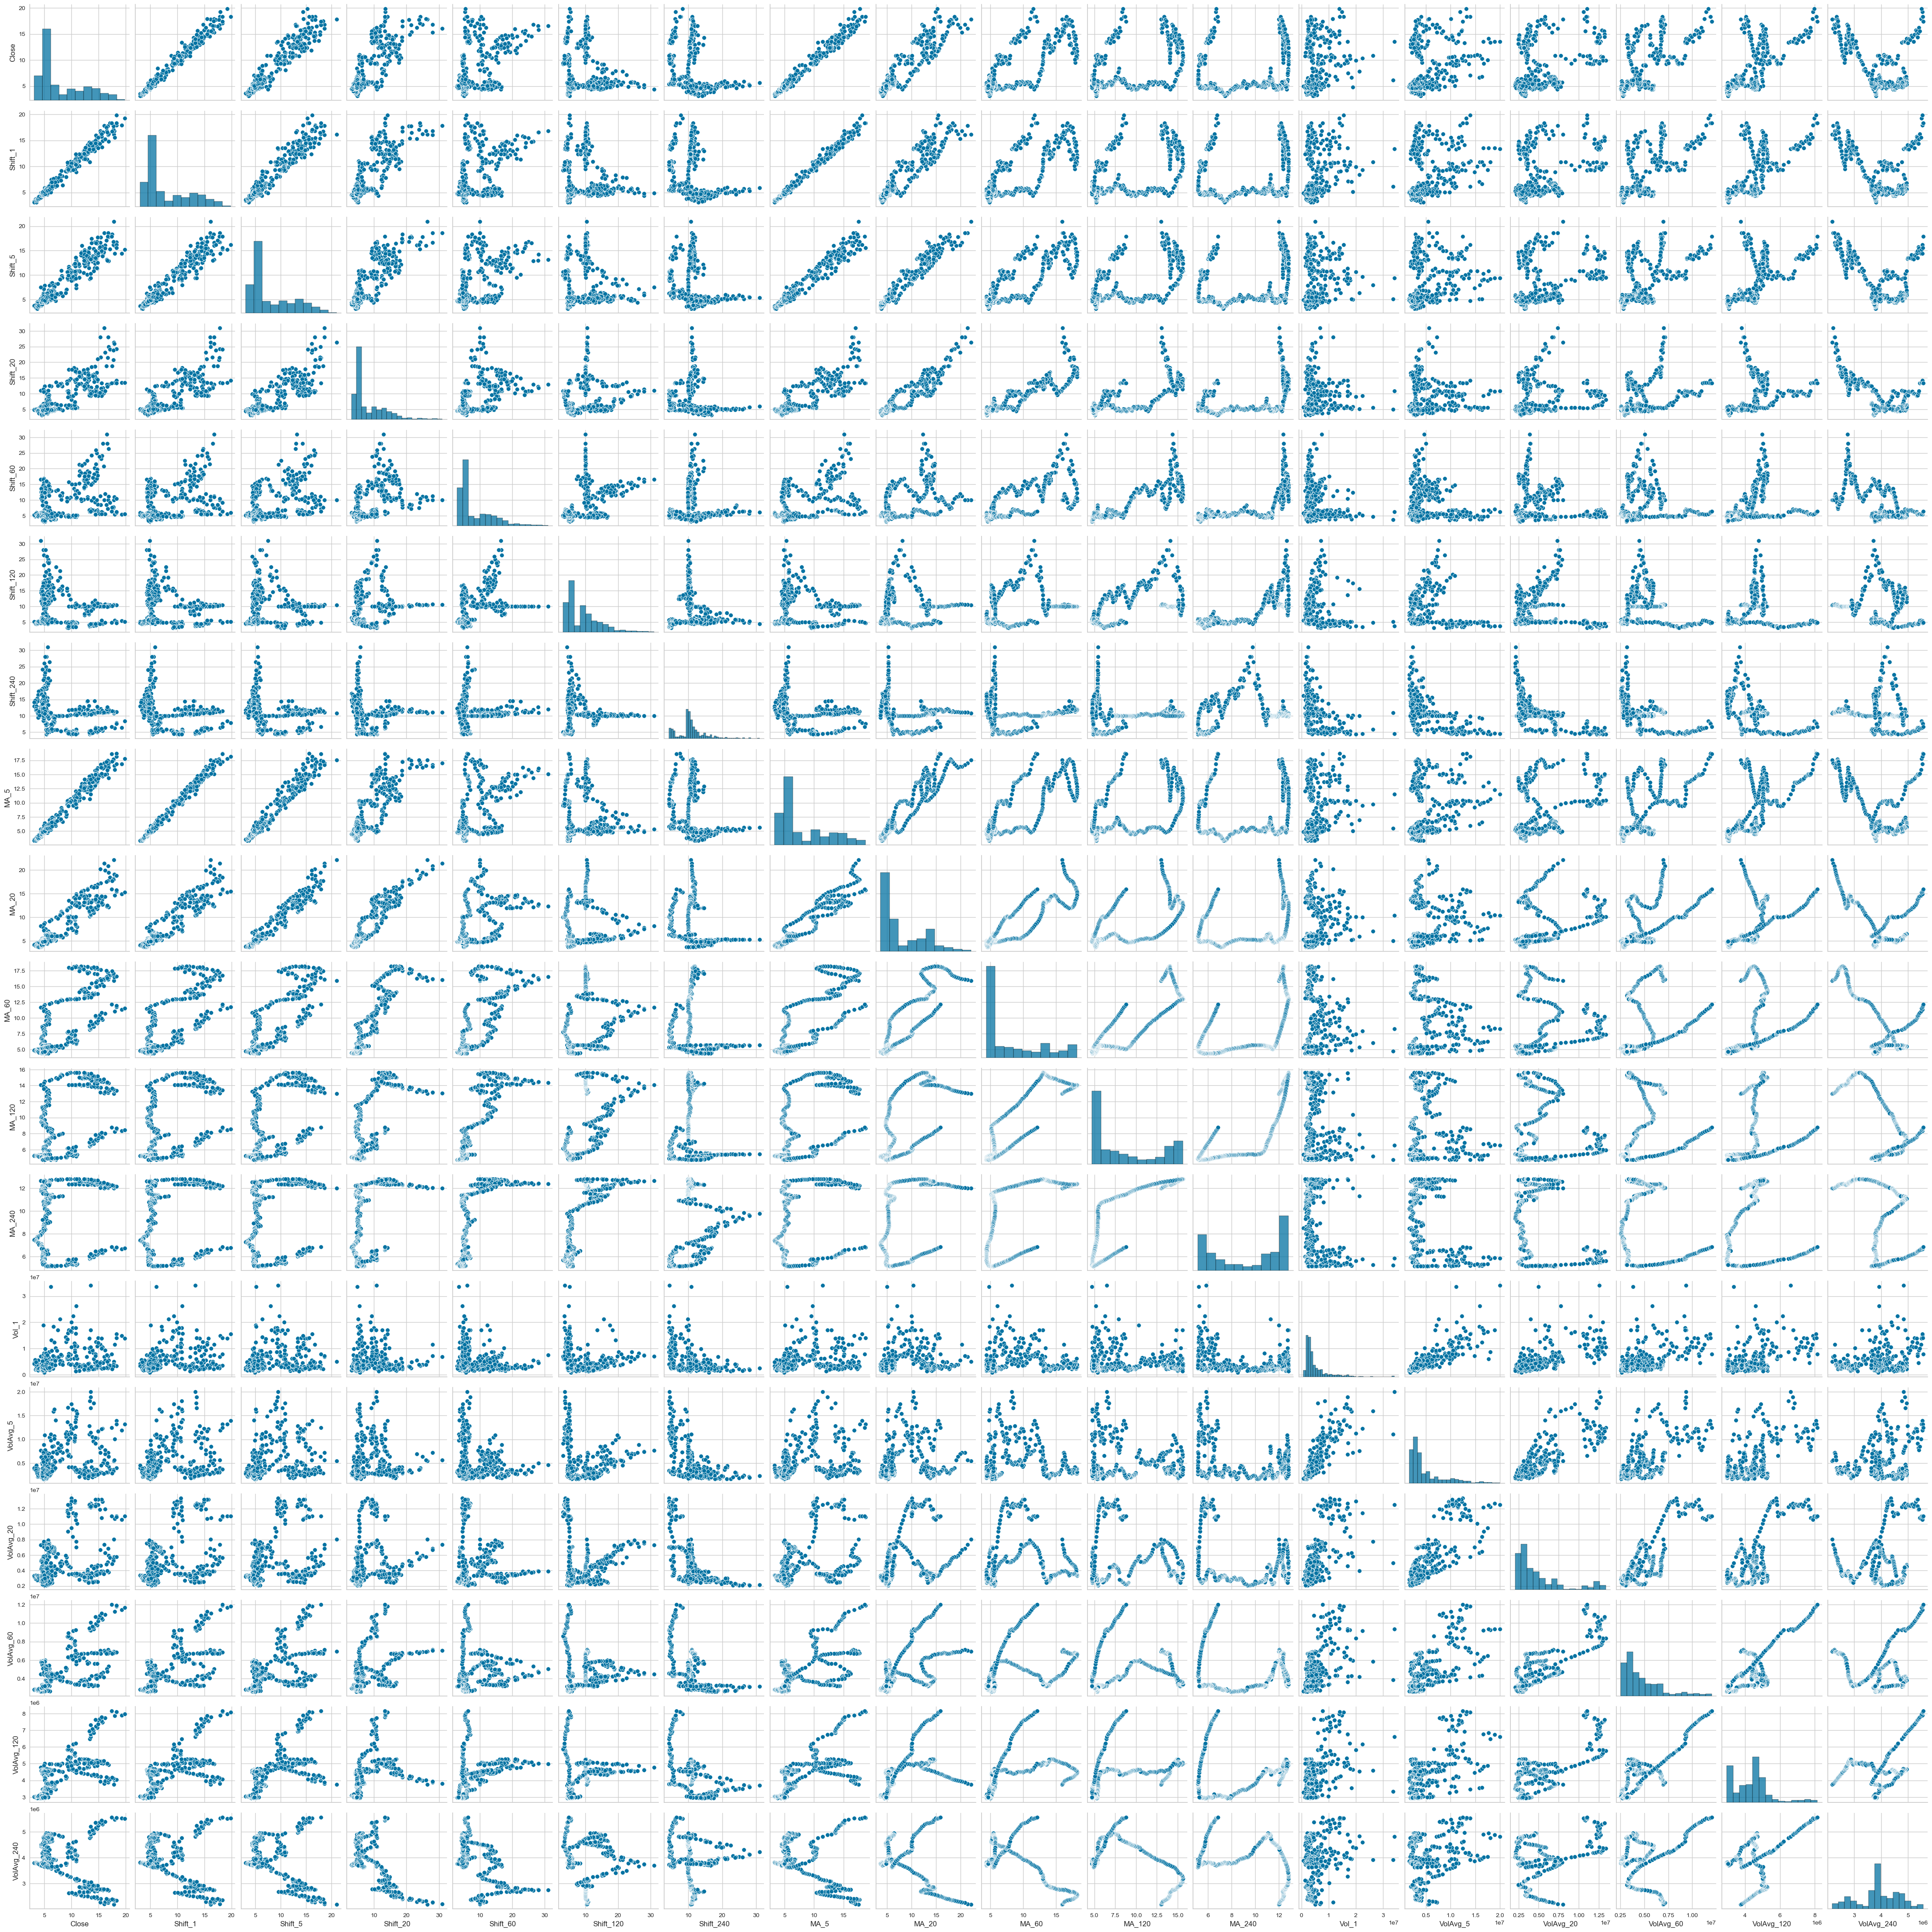

In [9]:
sns.pairplot(close)

4. Model Comparison

In [10]:
init_model = setup(
    session_id=123,
    data=close,
    target="Close",
    normalize=True,
    normalize_method="zscore",
    train_size=0.75,
    fold_strategy="kfold",
    fold=10
)

In [11]:
compare_models(n_select=10, sort="MSE")

Processing:   0%|          | 0/86 [00:00<?, ?it/s]

[BayesianRidge(),
 LinearRegression(n_jobs=-1),
 Ridge(random_state=123),
 HuberRegressor(),
 ExtraTreesRegressor(n_jobs=-1, random_state=123),
 OrthogonalMatchingPursuit(),
 RandomForestRegressor(n_jobs=-1, random_state=123),
 GradientBoostingRegressor(random_state=123),
 Lars(random_state=123),
 LGBMRegressor(n_jobs=-1, random_state=123)]

5. Create Model

In [12]:
br_model = create_model('br')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]